In [153]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import plotly.express as px
from scipy.optimize import minimize, brute, least_squares, leastsq, fsolve, curve_fit
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Everyone puts one markdown cell just like this before his/her code cell. <br>
Name: Your name<br>
Function: Your function<br>
describtion: input output info, general info about the algorithm, reference link if needed

Name: Sachin and Vaishnavi

Function: Historical simulation

Description: 

1) Defined a Function to calculate residual term i.e random walk providing a, b, rates, dt, model as inputs to find the error term or variance of the residual.

2) By using the optimization with Nelder - Mead technique we minimized the error term to find the best a, b that fits the model.

3) Calculated the sigma of the model by using the optimized a_new and b_new values.

In [154]:
rates_data = pd.read_excel("/content/drive/Shareddrives/FIM 500 project group/Data/Historical_Rates.xlsx", sheet_name=9)
rates_data.shape

(3242, 2)

In [163]:
# INPUTS
Starting_Date = '2022-08-01'
Num_Days = 50
dt = 1/252
model = 'CIR'
days_roll = 5 #no. of days rolling for moving average
skip = 5 #no. of days to skip, get data for every 'n' days
choice = 1 #select from 3 choices below
a=10
b=0.025
params = [a, b]

In [164]:
if choice == 1:
  # Selecting subset of dates
  rates = np.array(rates_data.loc[(rates_data['Date'] >= Starting_Date)].reset_index(drop=True).iloc[:Num_Days,1])/100
elif choice == 2:
  # Selecting subset of the data using moving average of rates
  rates_data['Close_ma'] = rates_data['Close'].rolling(days_roll).mean()
  rates = np.array(rates_data.loc[(rates_data['Date'] >= Starting_Date)].reset_index(drop=True).iloc[:Num_Days,2])/100
elif choice == 3:
  # Selecting data by skipping
  rates = np.array(rates_data.loc[(rates_data['Date'] >= Starting_Date)].reset_index(drop=True).iloc[:Num_Days:skip,1])/100
rates

array([0.02606, 0.02741, 0.02748, 0.02676, 0.0284 , 0.02765, 0.02797,
       0.02786, 0.02888, 0.02849, 0.02791, 0.02824, 0.02893, 0.0288 ,
       0.02989, 0.03037, 0.03054, 0.03106, 0.03026, 0.03035, 0.0311 ,
       0.0311 , 0.03133, 0.03265, 0.03193, 0.0334 , 0.03265, 0.03292,
       0.03321, 0.03362, 0.03422, 0.03412, 0.03459, 0.03448, 0.0349 ,
       0.03571, 0.0351 , 0.03708, 0.03697, 0.03878, 0.03964, 0.03705,
       0.03747, 0.03804, 0.03651, 0.03617, 0.03759, 0.03826, 0.03883,
       0.03888])

In [165]:
# Minimize method
def error_min(params, rates=rates, dt=dt, model=model):
    dr = rates[1:] - rates[:-1]
    drift = params[0] * (params[1] - rates) * dt
    if model == 'CIR':
        rw = (dr - drift[1:]) / np.sqrt(rates[1:])
        error = np.sum(rw ** 2)
    elif model == 'Vasicek':
        rw = (dr - drift[1:])
        error = np.sum(rw ** 2)
    return error*1000

# Least Squares method
def error_ls(params, rates=rates, dt=dt, model=model):
    dr = rates[1:] - rates[:-1]
    drift = params[0] * (params[1] - rates) * dt
    if model == 'CIR':
        rw = (dr - drift[1:]) / np.sqrt(rates[1:])
    elif model == 'Vasicek':
        rw = (dr - drift[1:])
    return rw

In [ ]:
# Run solver using minimize method

result_min = minimize(error_min, params, rates, method = 'SLSQP')
result_min

In [166]:
# Run solver using least squares method
a=50
b=0.025
params = [a, b]
result_ls = least_squares(error_ls, params, bounds=([0, 0], [100, 0.15]), method='trf')
result_ls.x

array([0.53510753, 0.15      ])

In [ ]:
# Run solver using Brute force method

result_br = brute(error_min, ranges=((0,2),(0.01,0.15)), Ns=20, full_output=True, finish=None)
result_br
#print(result[0])
#plt.imshow(np.log(result[3]))
#plt.colorbar()

#plt.figure(figsize=(12,12))
#sns.heatmap(np.log(result[3]))
#plt.show()

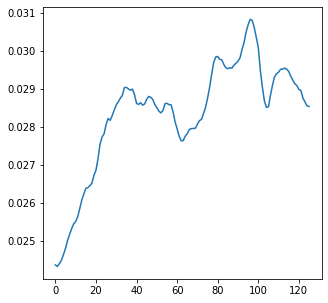

In [120]:
# Plotting rates
plt.figure(figsize=(5,5))
plt.plot(rates)

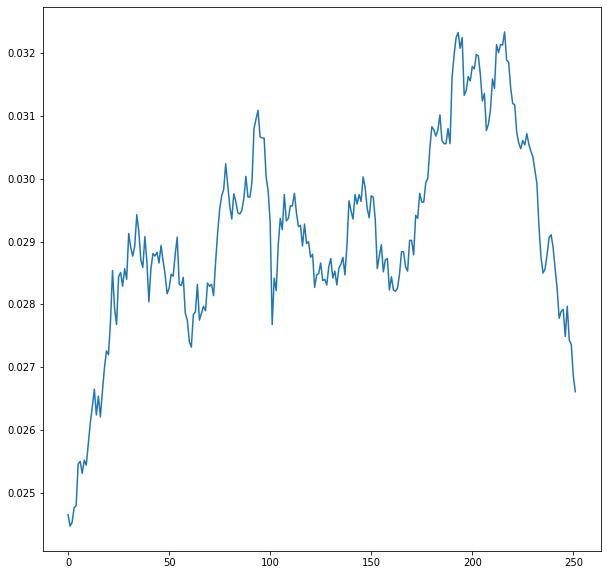

In [146]:
# Plotting rates
plt.figure(figsize=(10,10))
plt.plot(rates)

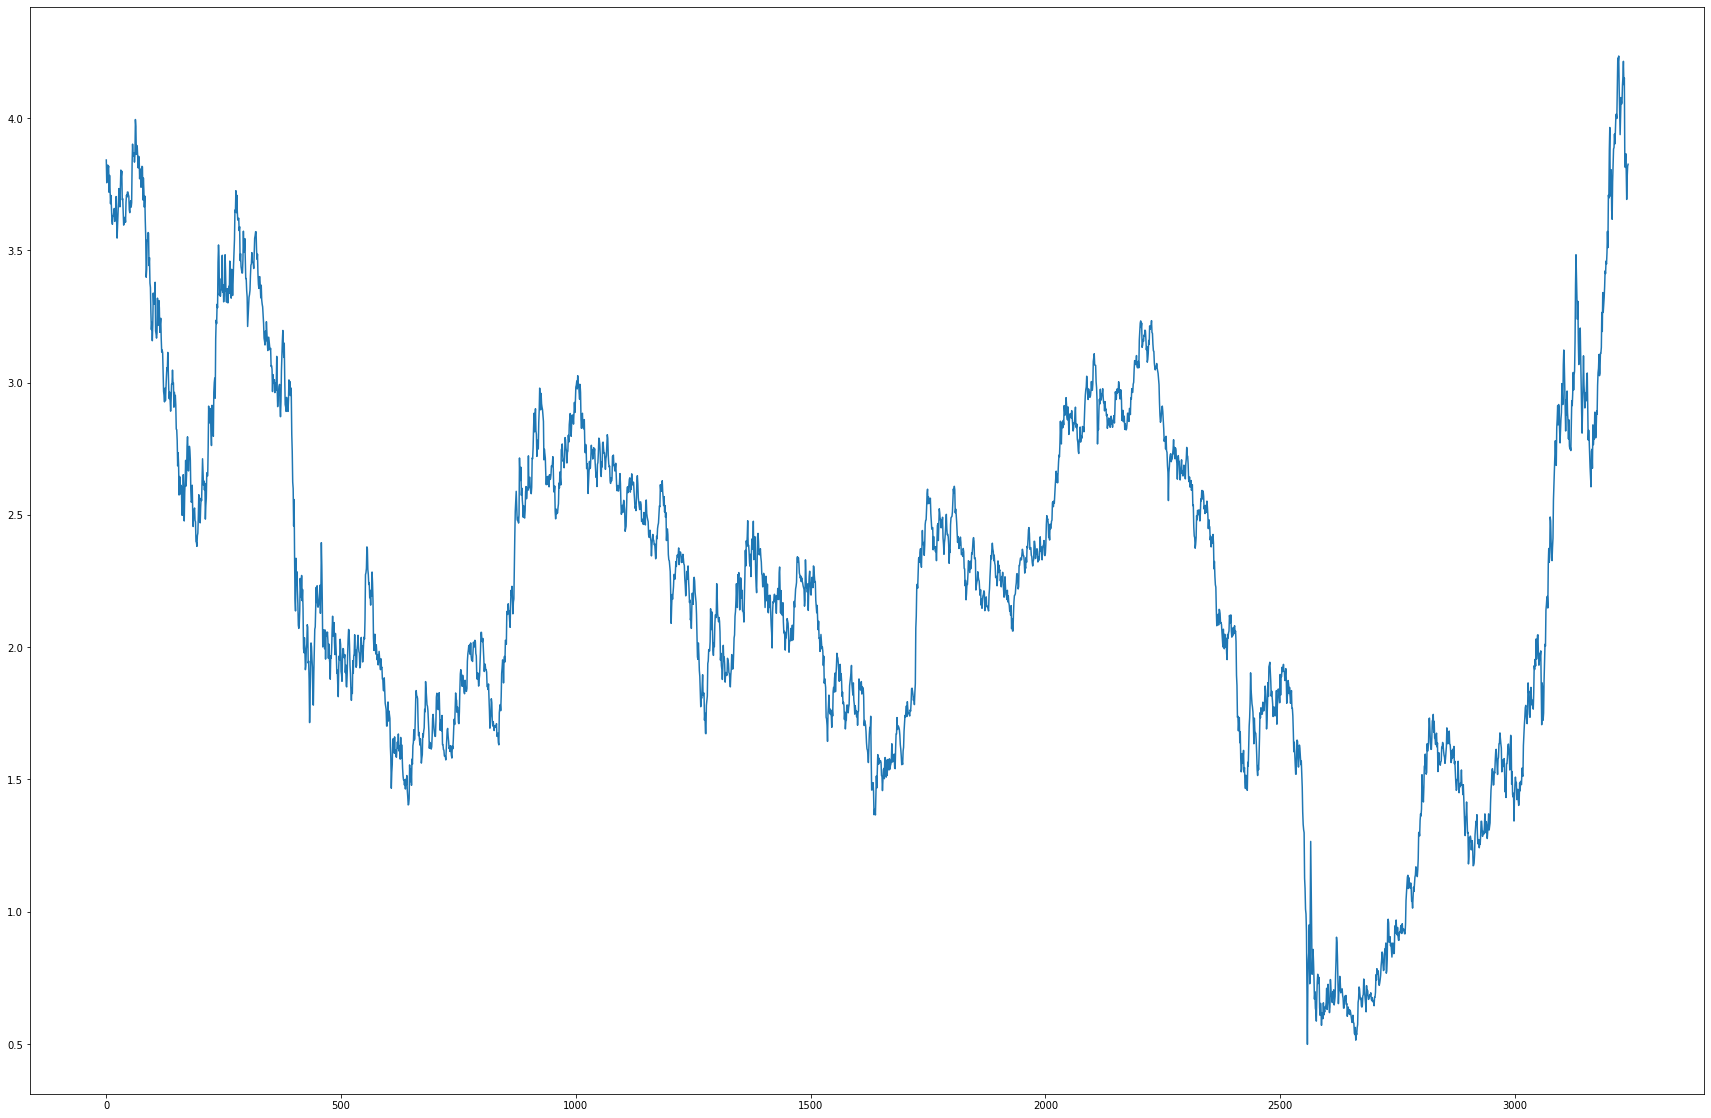

In [25]:
# Plotting rates
plt.figure(figsize=(30,20))
plt.plot(rates_data['Close'])

In [ ]:
# Analysis
a_new, b_new = result_min.x
drift_new = a_new*(b_new-rates)*(dt)
dr=rates[1:]-rates[:-1]
plt.plot(drift_new)
plt.plot(dr)

In [167]:
# Generating sigma

def sigma(a_new, b_new, rates, dt=dt, model = model):
    dr = rates[1:] - rates[:-1]
    drift = a_new * (b_new - rates) * dt
    if model == 'CIR':
        rw = (dr - drift[1:]) / np.sqrt(rates[1:])
        sig = np.mean(rw ** 2) / dt
    elif model == 'Vasicek':
        rw = (dr - drift[1:])
        sig = np.mean(rw ** 2) / dt   
    return sig

a_new, b_new = result_ls.x   
sig = sigma(a_new, b_new, rates)

In [162]:
# Print parameters - Vasicek
print(a_new, b_new, sig)

0.5749272344627735 0.1461039719263573 0.00018035157344080245


In [168]:
# Print parameters - CIR
print(a_new, b_new, sig)

0.5351075277083972 0.14999999984423737 0.0053507585153803475


In [ ]:
# Additional Analysis

methods = ['Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr']
result_list = []
for i in methods:
  result = minimize(error_min, params, rates, method = i)
  result_list = result_list + [result.fun]
print(result_list)
print(min(result_list))
print(sorted(result_list))